This notebook compares outputs from SimBio and libRoadRunner. Outputs from SimBio include varying simulator tolerances, which are found to be potentially important for generating reproducible stochastic simulation results.

Credit to Mauro Silberberg and Hernan Grecco for contributing to these results, including some code used in this notebook.

In [1]:
import biomodels
import csv
import itertools
import libssr
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import simbio.io.biomodels
from poincare.solvers import LSODA
from roadrunner import RoadRunner
from scipy import stats
from simbio import Simulator
from tqdm.auto import tqdm

model_id = 'BIOMD10'

model = simbio.io.biomodels.load(model_id)
sim = Simulator(model, backend='numba')

times = np.linspace(0, 6000, 21)  # [0, 300, ..., 6000]

rng = np.random.default_rng(0)
sample_sizes = {'data_100': 100,
                'data_1k': 1000,
                'data_10k': 10000}
tolerances = np.arange(-9, -2)
var_names = ['MAPK', 'MAPK_P', 'MAPK_PP', 'MKK', 'MKKK', 'MKKK_P', 'MKK_P', 'MKK_PP']
sig_level = 0.05

output_dir_root = 'results/compare_simbio_roadrunner'
output_dir_root_sb = os.path.join(output_dir_root, 'data', 'data_tolerances')
output_dir_root_rr = os.path.join(output_dir_root, 'data', 'data_rr')

# Generate SimBio results with varying tolerances

In [2]:
if not os.path.isdir(output_dir_root_sb):
    os.makedirs(output_dir_root_sb)

output_metadata_path = os.path.join(output_dir_root_sb, 'metadata.json')
if os.path.isfile(output_metadata_path):
    with open(output_metadata_path, 'r') as f:
        output_metadata = json.load(f)

else:
    output_metadata = {}
    for i, (ssize, tol) in enumerate(itertools.product(sample_sizes.values(), tolerances)):
        output_metadata['data/result' + str(i).zfill(5)] = dict(sample_size=ssize, tolerance=float(10.0 ** tol))

    with open(output_metadata_path, 'w') as f:
        json.dump(output_metadata, f, indent=4)

for rpath, edata in tqdm(output_metadata.items()):
    output_path = os.path.join(output_dir_root_sb, rpath)
    if os.path.isdir(output_path):
        continue

    ssize = edata['sample_size']
    tol = edata['tolerance']

    N_values = rng.uniform(0.9, 1.1, size=ssize)
    os.makedirs(output_path)

    for i, n in enumerate(tqdm(N_values, leave=False)):
    
        df = sim.solve(
            save_at=times,
            values={model.J0__n: n},
            solver=LSODA(atol=tol, rtol=tol)
        )
        with open(os.path.join(output_path, f'{i}.csv'), 'w') as f:
            df.to_csv(f)

  0%|          | 0/21 [00:00<?, ?it/s]

# Generate libRoadRunner results

In [3]:
rr = RoadRunner(RoadRunner.getParamPromotedSBML(biomodels.get_omex(model_id).master.read_text()))


def generate_rr_results(sz: int):

    results_rr = {n: np.zeros((sz, times.shape[0])) for n in var_names}

    for i, j0_n in tqdm(enumerate(rng.uniform(0.9, 1.1, size=sz)), total=sz, leave=False):
        rr.resetToOrigin()

        rr['J0_n'] = j0_n
        res = rr.simulate(times=times)
        for n in var_names:
            results_rr[n][i, :] = res[:, res.colnames.index(f'[{n}]')]

    return results_rr


for data_subdir, sample_size in sample_sizes.items():
    output_dir = os.path.join(output_dir_root_rr, data_subdir)
    if os.path.isdir(output_dir):
        continue
    
    os.makedirs(output_dir)

    res_rr = generate_rr_results(sample_size)
    headers = ['time'] + var_names
    for i in range(sample_size):
        data_i = {'time': times}
        for n in var_names:
            data_i[n] = res_rr[n][i, :]
        with open(os.path.join(output_dir, f'{i}.csv'), 'w') as f:
            writer = csv.DictWriter(f, fieldnames=headers)
            writer.writeheader()
            for j in range(times.shape[0]):
                writer.writerow({n: data_i[n][j] for n in headers})

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

# Compare results

In [4]:
def load_simbio_file(_fp: str):
    if not os.path.isfile(_fp):
        raise FileNotFoundError(_fp)

    times = []
    data = {}

    with open(_fp, 'r') as f:
        reader = csv.DictReader(f.readlines(), ['time'] + var_names)
        reader.__next__()
        for r in reader:
            t = float(r['time'])
            times.append(t)
            data[t] = {n: r[n] for n in var_names}

    times.sort()
    data_named = {n: np.zeros(len(times), dtype=float) for n in var_names}
    for i, t in enumerate(times):
        for n in var_names:
            data_named[n][i] = data[t][n]
    return np.array(times), {n: v for n, v in data_named.items()}


def load_simbio_data(_dirp: str):
    if not os.path.isdir(_dirp):
        raise NotADirectoryError(_dirp)

    res_files = [os.path.join(_dirp, f) for f in os.listdir(_dirp) if f.endswith('.csv')]
    if not res_files:
        raise FileNotFoundError(f'No results found')

    sample_size = len(res_files)
    # Sample one file to get times
    results_time = load_simbio_file(res_files[0])[0]
    num_times = results_time.shape[0]
    results = {n: np.zeros((sample_size, num_times)) for n in var_names}

    for i, f in enumerate(res_files):
        data = load_simbio_file(f)[1]
        for n in var_names:
            results[n][i, :] = data[n]

    return results_time, results

In [5]:
eval_num = 100
sig_figs = 12

def generate_efect_report(_sim_times, _results):
    num_steps = len(_sim_times)
    var_names = list(_results.keys())
    sample_size = _results[var_names[0]].shape[0]
    err_samples = libssr.test_reproducibility({k: libssr.round_arr_to_sigfigs(v, sig_figs) for k, v in _results.items()})[0]
    err_means = np.mean(err_samples)
    err_stdevs = np.std(err_samples)
    export_sample_size = sample_size // 2
    ecf_evals = np.ndarray((num_steps, len(var_names), eval_num, 2), dtype=float)
    ecf_tval = np.ndarray((num_steps, len(var_names)), dtype=float)
    for i, n in enumerate(var_names):
        sample_n = _results[n]
        for j in range(num_steps):
            sample_j = libssr.round_arr_to_sigfigs(sample_n[:export_sample_size, j], sig_figs)
            ecf_tval[j, i] = libssr.eval_final(sample_j)
            ecf_evals[j, i, :, :] = libssr.ecf(sample_j, 
                                               libssr.get_eval_info_times(eval_num, ecf_tval[j, i]))
    efect_report = libssr.EFECTReport.create(
        variable_names=var_names,
        simulation_times=_sim_times,
        sample_size=export_sample_size,
        ecf_evals=ecf_evals,
        ecf_tval=ecf_tval,
        ecf_nval=eval_num,
        error_metric_mean=err_means,
        error_metric_stdev=err_stdevs,
        sig_figs=sig_figs
    )
    return efect_report, err_samples


def compare_reports(_efect_report, _results):
    efect_error = 0.
    for i, n in enumerate(_efect_report.variable_names):
        sample_n = _results[n]
        for j in range(len(_efect_report.simulation_times)):
            ecf = libssr.ecf(libssr.round_arr_to_sigfigs(sample_n.T[j, :], _efect_report.sig_figs), 
                             libssr.get_eval_info_times(_efect_report.ecf_nval, _efect_report.ecf_tval[j, i]))
            efect_error = max(efect_error, libssr.ecf_compare(ecf, _efect_report.ecf_evals[j, i, :, :]))
    return efect_error


def pval_not_reproduced(_error_sampling, _efect_error):
    return libssr.pval(_error_sampling, _efect_error)

In [6]:
rr_sample_sizes_to_subdirs = {}

for subdir in sample_sizes:
    ssize = len([f for f in os.listdir(os.path.join(output_dir_root_rr, subdir)) if f.endswith('.csv')])
    rr_sample_sizes_to_subdirs[ssize] = subdir

rr_sample_sizes = list(rr_sample_sizes_to_subdirs.keys())
rr_sample_sizes.sort()

sb_sample_sizes = list(set([v['sample_size'] for v in output_metadata.values()]))
sb_sample_sizes.sort()

Generate EFECT Reports for RoadRunner data

In [7]:
ssr_output_dir_rr = os.path.join(output_dir_root, 'ssr', 'rr')

rr_efect_reports_dir = os.path.join(ssr_output_dir_rr, 'efect_reports')
rr_error_samples_dir = os.path.join(ssr_output_dir_rr, 'error_samples')
for d in [rr_efect_reports_dir, rr_error_samples_dir]:
    if not os.path.isdir(d):
        os.makedirs(d)

for subdir in tqdm(sample_sizes):

    efect_report_path = os.path.join(rr_efect_reports_dir, subdir + '.json')
    error_samples_path = os.path.join(rr_error_samples_dir, subdir + '.csv')
    if not os.path.isfile(efect_report_path) or not os.path.isfile(error_samples_path):
        results_time, results = load_simbio_data(os.path.join(output_dir_root_rr, subdir))
        efect_report, err_samples = generate_efect_report(results_time, results)
        with open(efect_report_path, 'w') as f:
            json.dump(efect_report.to_json(), f, indent=4)
        with open(error_samples_path, 'w') as f:
            pd.Series(err_samples).to_csv(f)

  0%|          | 0/3 [00:00<?, ?it/s]

Generate EFECT reports for SimBio data

In [8]:
ssr_output_dir_sb = os.path.join(output_dir_root, 'ssr', 'simbio')

sb_efect_reports_dir = os.path.join(ssr_output_dir_sb, 'efect_reports')
sb_error_samples_dir = os.path.join(ssr_output_dir_sb, 'error_samples')
for d in [sb_efect_reports_dir, sb_error_samples_dir]:
    if not os.path.isdir(d):
        os.makedirs(d)

for subdir_full in tqdm(output_metadata):

    subdir = subdir_full.replace('data/', '')

    efect_report_path = os.path.join(sb_efect_reports_dir, subdir + '.json')
    error_samples_path = os.path.join(sb_error_samples_dir, subdir + '.csv')
    if not os.path.isfile(efect_report_path) or not os.path.isfile(error_samples_path):
        results_time, results = load_simbio_data(os.path.join(output_dir_root_sb, subdir_full))
        efect_report, err_samples = generate_efect_report(results_time, results)
        with open(efect_report_path, 'w') as f:
            json.dump(efect_report.to_json(), f, indent=4)
        with open(error_samples_path, 'w') as f:
            pd.Series(err_samples).to_csv(f)

  0%|          | 0/21 [00:00<?, ?it/s]

Compare results among SimBio results with different tolerances by sample size

In [9]:
sb_compare_sb_data = {
    'Sample size': [],
    'Tolerance - Modeler': [],
    'Tolerance - Curator': [],
    'EFECT Error': [],
    'Rejection p-value': []
}
sb_md_table = {}

for subdir_full, mdata in output_metadata.items():

    subdir = subdir_full.replace('data/', '')
    ssize = mdata['sample_size']
    tol = mdata['tolerance']
    try:
        sb_md_table[ssize][tol] = subdir
    except KeyError:
        sb_md_table[ssize] = {tol: subdir}

for ssize in tqdm(sb_md_table):
    for tol_modeler in tqdm(sb_md_table[ssize], leave=False):

        name_modeler = sb_md_table[ssize][tol_modeler]
        efect_report_modeler_path = os.path.join(sb_efect_reports_dir, name_modeler + '.json')
        error_samples_modeler_path = os.path.join(sb_error_samples_dir, name_modeler + '.csv')

        with open(efect_report_modeler_path, 'r') as f:
            efect_report_modeler = libssr.EFECTReport.from_json(json.load(f))
        with open(error_samples_modeler_path, 'r') as f:
            error_samples_modeler = pd.read_csv(f).values[:, 1].tolist()

        for tol_curator in sb_md_table[ssize]:
            if tol_modeler == tol_curator:
                continue

            name_curator = sb_md_table[ssize][tol_curator]

            subdir_full = 'data/' + name_curator
            results_curator = load_simbio_data(os.path.join(output_dir_root_sb, subdir_full))[1]
            
            efect_error = compare_reports(efect_report_modeler, {k: v[:ssize//2, :] for k, v in results_curator.items()})
            pval_rejection = pval_not_reproduced(error_samples_modeler, efect_error)

            sb_compare_sb_data['Sample size'].append(ssize)
            sb_compare_sb_data['Tolerance - Modeler'].append(tol_modeler)
            sb_compare_sb_data['Tolerance - Curator'].append(tol_curator)
            sb_compare_sb_data['EFECT Error'].append(efect_error)
            sb_compare_sb_data['Rejection p-value'].append(pval_rejection)

sb_compare_sb = pd.DataFrame(sb_compare_sb_data)
sb_compare_sb['Reproduced'] = sb_compare_sb['Rejection p-value'] > sig_level
sb_compare_sb

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,Sample size,Tolerance - Modeler,Tolerance - Curator,EFECT Error,Rejection p-value,Reproduced
0,100,1.000000e-09,1.000000e-08,0.384079,1.000000,True
1,100,1.000000e-09,1.000000e-07,0.603834,0.958028,True
2,100,1.000000e-09,1.000000e-06,0.494605,1.000000,True
3,100,1.000000e-09,1.000000e-05,0.569648,1.000000,True
4,100,1.000000e-09,1.000000e-04,0.413312,1.000000,True
...,...,...,...,...,...,...
121,10000,1.000000e-03,1.000000e-08,0.275471,0.001249,False
122,10000,1.000000e-03,1.000000e-07,0.250576,0.001249,False
123,10000,1.000000e-03,1.000000e-06,0.246971,0.001249,False
124,10000,1.000000e-03,1.000000e-05,0.254447,0.001249,False


In [10]:
sb_compare_sb[~sb_compare_sb['Reproduced']].sort_values(by=['Tolerance - Curator', 'Tolerance - Modeler'])

,Sample size,Tolerance - Modeler,Tolerance - Curator,EFECT Error,Rejection p-value,Reproduced
120,10000,1.000000e-03,1.000000e-09,0.255907,0.001249,False
121,10000,1.000000e-03,1.000000e-08,0.275471,0.001249,False
122,10000,1.000000e-03,1.000000e-07,0.250576,0.001249,False
81,1000,1.000000e-03,1.000000e-06,0.296291,0.024831,False
123,10000,1.000000e-03,1.000000e-06,0.246971,0.001249,False
82,1000,1.000000e-03,1.000000e-05,0.282192,0.031925,False
124,10000,1.000000e-03,1.000000e-05,0.254447,0.001249,False
125,10000,1.000000e-03,1.000000e-04,0.264227,0.001249,False
89,10000,1.000000e-09,1.000000e-03,0.256532,0.001290,False
95,10000,1.000000e-08,1.000000e-03,0.275721,0.002494,False


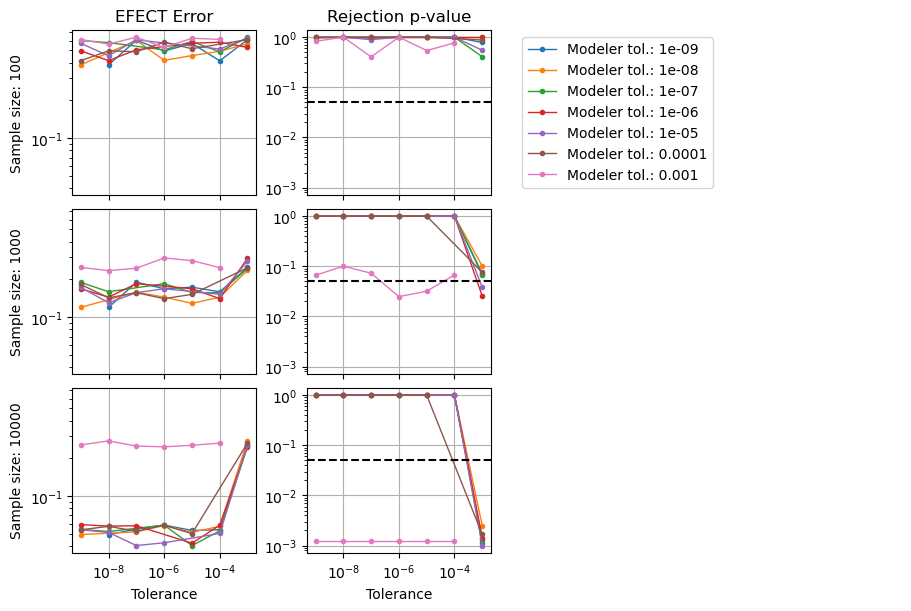

In [11]:
tab10 = plt.color_sequences['tab10']
fig, axs = plt.subplots(len(sb_sample_sizes), 3, layout='compressed', figsize=(3 * 3, 2 * len(sb_sample_sizes)), sharex=True, sharey='col')

for i, ssize in enumerate(sb_sample_sizes):
    sb_compare_sb_ssize = sb_compare_sb[sb_compare_sb['Sample size'] == ssize]

    for j, tol_m in enumerate(sb_compare_sb_ssize['Tolerance - Modeler'].unique()):
        sb_compare_sb_tol_m = sb_compare_sb_ssize[sb_compare_sb_ssize['Tolerance - Modeler'] == tol_m]
        sb_compare_sb_tol_m = sb_compare_sb_tol_m.sort_values(by='Tolerance - Curator')

        axs[i][0].plot(sb_compare_sb_tol_m['Tolerance - Curator'], sb_compare_sb_tol_m['EFECT Error'], 
                       marker='o',
                       markersize=3.,
                       linewidth=1.,
                       label=f'Modeler tol.: {tol_m}', 
                       color=tab10[j])
        axs[i][1].plot(sb_compare_sb_tol_m['Tolerance - Curator'], sb_compare_sb_tol_m['Rejection p-value'], 
                       marker='o',
                       markersize=3.,
                       linewidth=1.,
                       label=f'Modeler tol.: {tol_m}', 
                       color=tab10[j])

for i, axi in enumerate(axs):
    for ax in axi:
        ax.grid(True)
        ax.set_xscale('log')
        ax.set_yscale('log')
    axi[0].set_ylabel(f'Sample size: {sb_sample_sizes[i]}')
    axi[1].axhline(sig_level, color='black', linestyle='--')
    axi[2].axis(False)
axs[0][1].legend(loc='center right', bbox_to_anchor=(2.25, 0.5))
axs[0][0].set_title('EFECT Error')
axs[0][1].set_title('Rejection p-value')
axs[-1][0].set_xlabel('Tolerance')
_ = axs[-1][1].set_xlabel('Tolerance')

Compare results from RoadRunner and SimBio results with different tolerances by sample size

In [12]:
sample_sizes = list(set(rr_sample_sizes).intersection(sb_sample_sizes))
sample_sizes.sort()

sb_compare_rr_data = {
    'Sample size': [],
    'Tolerance': [],
    'EFECT Error (R)': [],
    'EFECT Error (S)': [],
    'Rejection p-value (R)': [],
    'Rejection p-value (S)': []
}

for ssize in tqdm(sample_sizes):
    name_rr = rr_sample_sizes_to_subdirs[ssize]

    results_rr = load_simbio_data(os.path.join(output_dir_root_rr, name_rr))[1]

    efect_report_rr_path = os.path.join(rr_efect_reports_dir, name_rr + '.json')
    error_samples_rr_path = os.path.join(rr_error_samples_dir, name_rr + '.csv')

    with open(efect_report_rr_path, 'r') as f:
        efect_report_rr = libssr.EFECTReport.from_json(json.load(f))
    with open(error_samples_rr_path, 'r') as f:
        error_samples_rr = pd.read_csv(f).values[:, 1].tolist()

    for tol, name_sb in tqdm(sb_md_table[ssize].items(), leave=False):

        results_sb = load_simbio_data(os.path.join(output_dir_root_sb, 'data/' + name_sb))[1]

        efect_report_sb_path = os.path.join(sb_efect_reports_dir, name_sb + '.json')
        error_samples_sb_path = os.path.join(sb_error_samples_dir, name_sb + '.csv')

        with open(efect_report_sb_path, 'r') as f:
            efect_report_sb = libssr.EFECTReport.from_json(json.load(f))
        with open(error_samples_sb_path, 'r') as f:
            error_samples_sb = pd.read_csv(f).values[:, 1].tolist()

        efect_error = compare_reports(efect_report_rr, {k: v[:ssize//2, :] for k, v in results_sb.items()})
        pval_rejection = pval_not_reproduced(error_samples_rr, efect_error)

        sb_compare_rr_data['Sample size'].append(ssize)
        sb_compare_rr_data['Tolerance'].append(tol)
        sb_compare_rr_data['EFECT Error (R)'].append(efect_error)
        sb_compare_rr_data['Rejection p-value (R)'].append(pval_not_reproduced(error_samples_rr, efect_error))

        efect_error = compare_reports(efect_report_sb, {k: v[:ssize//2, :] for k, v in results_rr.items()})
        pval_rejection = pval_not_reproduced(error_samples_sb, efect_error)

        sb_compare_rr_data['EFECT Error (S)'].append(efect_error)
        sb_compare_rr_data['Rejection p-value (S)'].append(pval_not_reproduced(error_samples_sb, efect_error))

sb_compare_rr = pd.DataFrame(sb_compare_rr_data)
sb_compare_rr['Reproduced (R)'] = sb_compare_rr['Rejection p-value (R)'] > sig_level
sb_compare_rr['Reproduced (S)'] = sb_compare_rr['Rejection p-value (S)'] > sig_level
sb_compare_rr

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,Sample size,Tolerance,EFECT Error (R),EFECT Error (S),Rejection p-value (R),Rejection p-value (S),Reproduced (R),Reproduced (S)
0,100,1.000000e-09,0.001839,0.001838,1.000000,1.000000,True,True
1,100,1.000000e-08,0.384048,0.384183,1.000000,1.000000,True,True
2,100,1.000000e-07,0.603785,0.599998,0.881598,0.977175,True,True
3,100,1.000000e-06,0.494613,0.496106,1.000000,1.000000,True,True
4,100,1.000000e-05,0.569668,0.569807,1.000000,1.000000,True,True
5,100,1.000000e-04,0.413387,0.414448,1.000000,1.000000,True,True
6,100,1.000000e-03,0.608731,0.609595,0.754636,0.861652,True,True
7,1000,1.000000e-09,0.163885,0.163784,1.000000,1.000000,True,True
8,1000,1.000000e-08,0.146842,0.147310,1.000000,1.000000,True,True
9,1000,1.000000e-07,0.165464,0.165842,1.000000,1.000000,True,True


In [13]:
sb_compare_rr[(~sb_compare_rr['Reproduced (R)']) | (~sb_compare_rr['Reproduced (S)'])]

,Sample size,Tolerance,EFECT Error (R),EFECT Error (S),Rejection p-value (R),Rejection p-value (S),Reproduced (R),Reproduced (S)
13,1000,0.001,0.311375,0.309660,0.020653,0.020316,False,False
20,10000,0.001,0.261405,0.262036,0.001427,0.001249,False,False


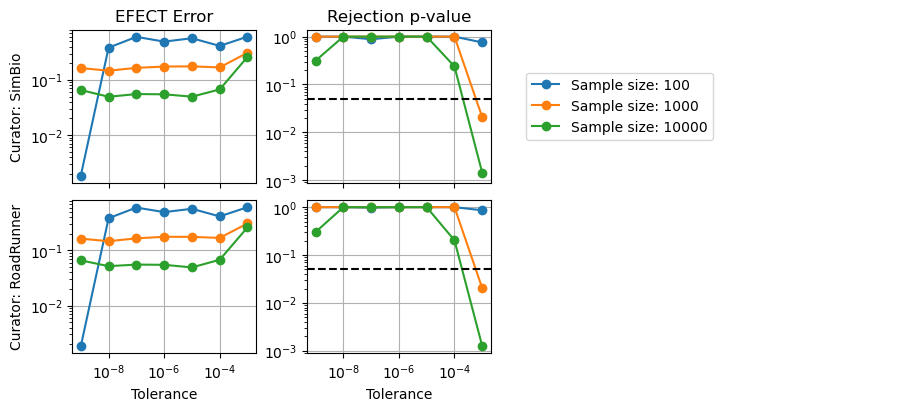

In [14]:
tab10 = plt.color_sequences['tab10']
fig, axs = plt.subplots(2, 3, layout='compressed', figsize=(3 * 3, 2 * 2), sharex=True, sharey='col')

for i, ssize in enumerate(sample_sizes):
    sb_compare_rr_ssize = sb_compare_rr[sb_compare_rr['Sample size'] == ssize]
    sb_compare_rr_ssize = sb_compare_rr_ssize.sort_values(by='Tolerance')

    for j, lab in enumerate(['R', 'S']):

        axs[j][0].plot(sb_compare_rr_ssize['Tolerance'], sb_compare_rr_ssize[f'EFECT Error ({lab})'], 
                       marker='o',
                       label=f'Sample size: {ssize}', 
                       color=tab10[i])
        axs[j][1].plot(sb_compare_rr_ssize['Tolerance'], sb_compare_rr_ssize[f'Rejection p-value ({lab})'], 
                       marker='o',
                       label=f'Sample size: {ssize}', 
                       color=tab10[i])

for i, axi in enumerate(axs):
    for ax in axi:
        ax.grid(True)
        ax.set_xscale('log')
        ax.set_yscale('log')
    axi[1].axhline(sig_level, color='black', linestyle='--')
    axi[2].axis(False)
axs[0][0].set_ylabel('Curator: SimBio')
axs[1][0].set_ylabel('Curator: RoadRunner')
axs[0][1].legend(loc='center right', bbox_to_anchor=(2.25, 0.5))
axs[0][0].set_title('EFECT Error')
axs[0][1].set_title('Rejection p-value')
axs[-1][0].set_xlabel('Tolerance')
_ = axs[-1][1].set_xlabel('Tolerance')